# 🌈⏰🌊 time-series spectra 

This example notebook provides quick visualizations to characterize a set of time-series stellar spectra for a transiting exoplanet, using the [`chromatic` toolkit](https://zkbt.github.io/chromatic/). This notebook can be run before you have fit any models to the data, requiring only the data themselves and a few details about the planet. To access this notebook, you might want to:
- Download it from [GitHub](https://github.com/zkbt/chromatic/blob/main/docs/example-timeseries-spectra.ipynb) (click 'Raw' to download the `.ipynb` file) and run on your own computer.
- Open in [Google Colab](https://colab.research.google.com/github/zkbt/chromatic/blob/main/docs/example-timeseries-spectra.ipynb), load your data into that interactive session, and run everything online.

You should be able to modify just code cells in the **💻 Load the Data + 🪐 Describe the Planet** section, and then run the entire notebook to automatically generate visualizations.

## 💾 Make Sure `chromatic` is Installed

If you don't already have `chromatic` installed, run the following command. 

In [1]:
!pip install chromatic-lightcurves --upgrade --quiet

Once `chromatic` is installed, you should have access to all the tools you need!

In [2]:
from chromatic import *

In [3]:
version()

'0.3.6'

## 🧑‍💻 Load the Data + 🪐 Describe the Planet

Let's load the data into a `chromatic` 🌈 object. If you encounter errors loading your dataset, try specifying the file format with `read_rainbow(filename, format=...)` as described in the [Reading/Writing a 🌈](https://zkbt.github.io/chromatic/io/). Let's also associated a title with this object, which will automatically appear in most plots.

In [4]:
filename = "example-datasets/stsci/jw02734*x1dints.fits"
rainbow = read_rainbow(filename)
rainbow.title = "WASP-96b | NIRISS | x1dints"


🌈 Warning: 
Loading NIRISS spectroscopic `order=1``. Three orders are available,
and you can set which (1,2,3) you want to read with the `order=` option.

🌈 Warning: No wavelength unit was found; assuming 'micron'.
🌈 Warning: 
No `int_times` extension was found in the first file
example-datasets/stsci/jw02734002001_04101_00001-seg001_nis_x1dints.fits)
We're estimating the times from the `sci` extension
using the TDB-BEG, TDB-END, and EFFINTTM keywords.

🌈 Warning: 
Times were set by linearly interpolating between the exposure
start and end points. It's very possible these times are off
by at least a few seconds and possibly up to the duration
of one integration (= 76.916s)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]


🌈 Warning: 
The 2048 input wavelengths were not monotonically increasing.
<🌈(2048w, 280t)> has been sorted from lowest to highest wavelength.
If you want to recover the original wavelength order, the original
wavelength indices are available in `rainbow.original_wave_index`.


Let's define a few basic parameters describing the planet. These will help make the plots easier to interpret and be used to mask out the transit for noise characterization. If you need a period, epoch, and duration for your transit, you might find them in the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/).

In [5]:
period = 3.4252577 * u.day
t0 = 2459111.30170 * u.day
duration = 2.4264 * u.hour * 1.1

Let's set some very basic plotting defaults. These will try to sync up the vertical limits of light curve plots with the color maps of 2D flux maps.

In [6]:
vmin = 0.98
vmax = 1.005
ylim = [vmin, vmax]

## 🎨 Make Basic Visualizations

Let's make some plots to get an overall sense for the dataset. First of all, let's normalize by dividing through by the median stellar spectrum and display a 2D map of the flux. 

In [7]:
normalized = rainbow.normalize()

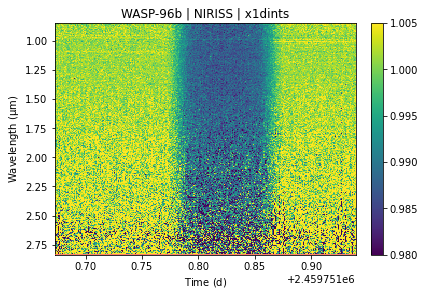

In [8]:
normalized.pcolormesh(vmin=vmin, vmax=vmax);

Let's trim any bad wavelengths off the edges and phase-fold these data to the planet's known period and time of mid-transit. This latter step is just to make the times easier to interpret.

In [9]:
tidied = normalized.trim().fold(period=period, t0=t0)

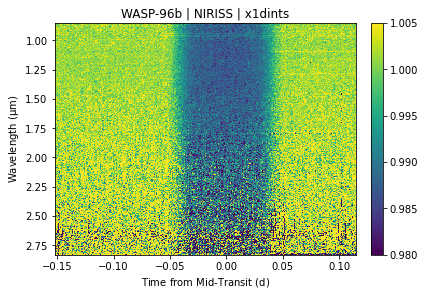

In [10]:
tidied.pcolormesh(vmin=vmin, vmax=vmax);

Now let's bin to a fixed wavelength resolution $R=\lambda/\Delta\lambda$ and cadence $dt$. Be averaging together multiple wavelengths and/or times, we'll decrease the noise (at the cost of worse resolution); some features may become more apparently with stronger binning, as long as the bins aren't so large to smooth features away. We'll normalize again after binning, once the noise has been averaged down a little bit.

In [11]:
binned = tidied.bin(R=100, dt=2 * u.minute).normalize()

  0%|          | 0/2039 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

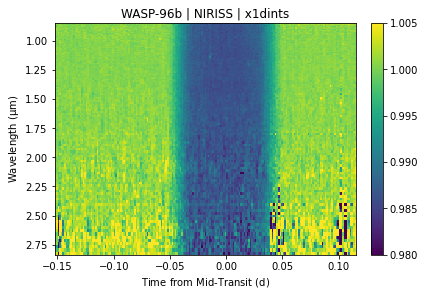

In [12]:
binned.pcolormesh(vmin=vmin, vmax=vmax);

If we want to see how these flux maps line up to light curves, we can use the interactive exploration tool to drag and select different wavelength ranges, and plot the (unweighted) average light curves for them. Being able to select particular wavelength ranges allows us to zoom in on features of interest or trends with wavelength.

In [13]:
binned.imshow_interact(ylim=ylim)

  0%|          | 0/121 [00:00<?, ?it/s]

alt.HConcatChart(...)

Let's make an animation the flips through wavelength bins. Animations can be useful way to to let your eyes take in a lot of light curves in quick succession, to see how trends or noise sources change with wavelength.

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

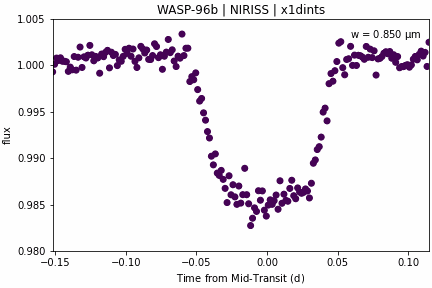

In [14]:
binned.animate_lightcurves(ylim=ylim)

Let's look at the weighted average light curve, integrating together all the available wavelengths. The binned uncertainties should be smaller than any individual wavelength bin, so this should hopefully be a very precise light curve!

  0%|          | 0/193 [00:00<?, ?it/s]

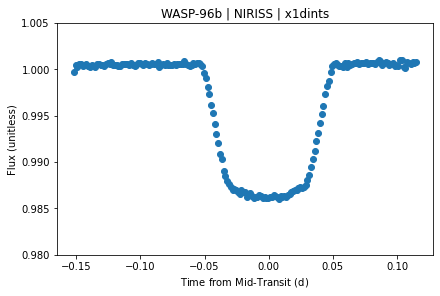

In [15]:
binned.plot_average_lightcurve(ylim=ylim)

Finally, let's bin the data to very low spectral resolution, and then plot a stack of light curves for the separate wavelengths. 

In [16]:
really_binned = binned.bin(R=10)

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

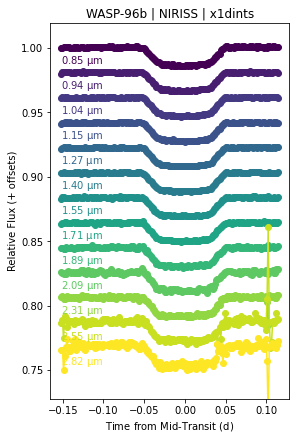

In [17]:
really_binned.plot();

## 🌫 Characterize the Noise

After looking closely at the transit in the data, it can be useful to filter or mask out the transit. By creating a dataset that we expect to be mostly flat, we can characterize the noise properties. First, let's simply mask out the transit and look only at the data before and after it.

In [18]:
out_of_transit = (
    rainbow.trim().mask_transit(period=period, t0=t0, duration=duration).normalize()
)

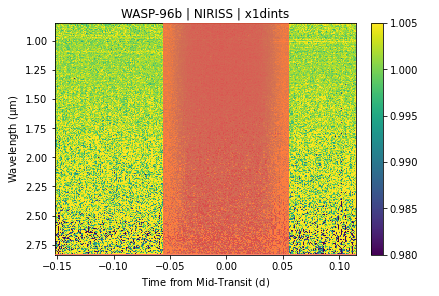

In [19]:
out_of_transit.pcolormesh(vmin=vmin, vmax=vmax);

Because unbinned data have the small wavelength and time intervals, and therefore contain the relatively few photons per bin, their expected uncertainties will be large. As we bin to larger wavelength intervals (lower resolution) and longer time intervals, the expected uncertainties will decrease, revealing increasingly subtle features. 

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

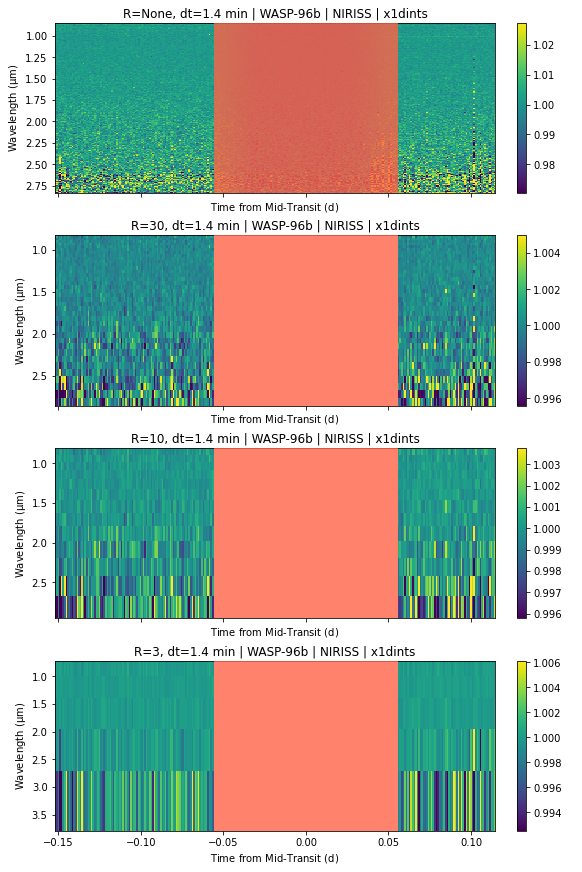

In [20]:
resolutions = [None, 30, 10, 3]
if rainbow.ntime > 1e4:
    dt = 1 * u.minute
else:
    dt = None

binned_rainbows = {}
N = len(resolutions)
fi, ax = plt.subplots(N, 1, sharex=True, figsize=(8, N * 3))
for i, R in enumerate(resolutions):
    binned_rainbows[R] = out_of_transit.bin(R=R, dt=dt).normalize()
    binned_rainbows[R].pcolormesh(ax=ax[i])
    plt.title(f"R={R}, dt={binned_rainbows[R].dt:.2} | {ax[i].get_title()}")

If the data were perfect and simple, we would expect the scatter in the out-of-transit flux to match the expected uncertainties for each wavelength. Let's compare the expected and measured scatters, after binning down in wavelength and time. If the measured scatter does not decrease as expected when averaging bins together, there is probably some systematic noise that is correlated across wavelength and/or time that should be addressed.


🌈 Warning: All-NaN slice encountered

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]


🌈 Warning: All-NaN slice encountered
🌈 Warning: Warning: converting a masked element to nan.

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

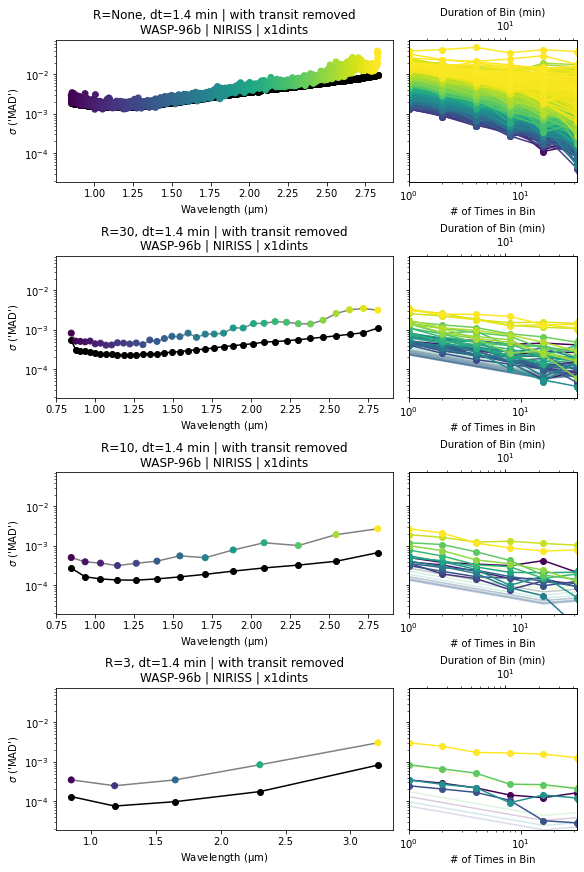

In [21]:
fi, ax = plt.subplots(
    N, 2, sharey=True, figsize=(8, N * 3), gridspec_kw=dict(width_ratios=[2, 1])
)
for i, R in enumerate(binned_rainbows):
    binned_rainbows[R].plot_noise_comparison(ax=ax[i, 0], method="MAD")
    plt.title(
        f"R={R}, dt={binned_rainbows[R].dt:.2} | with transit removed\n{ax[i,0].get_title()}"
    )
    binned_rainbows[R].plot_noise_comparison_in_bins(ax=ax[i, 1], method="MAD")

It's possible that excess scatter might be the result of very smooth trends in time. Let's repeat the above analysis of the dataset binned to different wavelength and time intervals, but also remove a smooth quadratic trend in time, which could imagine might be either instrumental or astrophysical. 

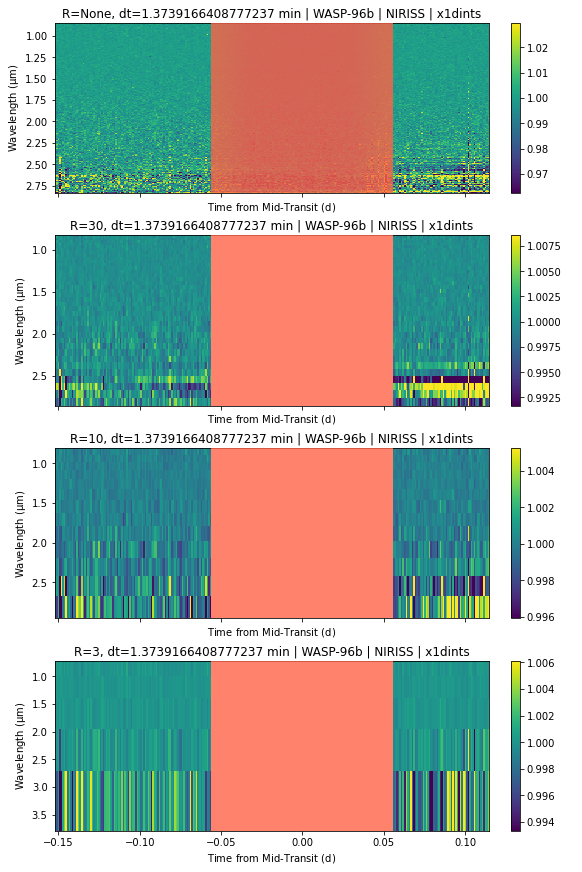

In [22]:
fi, ax = plt.subplots(N, 1, sharex=True, figsize=(8, N * 3))
for i, R in enumerate(binned_rainbows):
    with_trend_removed = binned_rainbows[R].remove_trends(method="polyfit", deg=2)
    with_trend_removed.pcolormesh(ax=ax[i])
    plt.title(f"R={R}, dt={binned_rainbows[R].dt:2} | {ax[i].get_title()}")


🌈 Warning: All-NaN slice encountered
🌈 Warning: 
The `remove_trends` function was applied to this `Rainbow`,
making it very plausible that some long-timescale signals
and/or noise have been suppressed. Be suspicious of binned
scatters on long timescales.


  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]


🌈 Warning: All-NaN slice encountered
🌈 Warning: Warning: converting a masked element to nan.
🌈 Warning: 
The `remove_trends` function was applied to this `Rainbow`,
making it very plausible that some long-timescale signals
and/or noise have been suppressed. Be suspicious of binned
scatters on long timescales.


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]


🌈 Warning: 
The `remove_trends` function was applied to this `Rainbow`,
making it very plausible that some long-timescale signals
and/or noise have been suppressed. Be suspicious of binned
scatters on long timescales.


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]


🌈 Warning: 
The `remove_trends` function was applied to this `Rainbow`,
making it very plausible that some long-timescale signals
and/or noise have been suppressed. Be suspicious of binned
scatters on long timescales.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

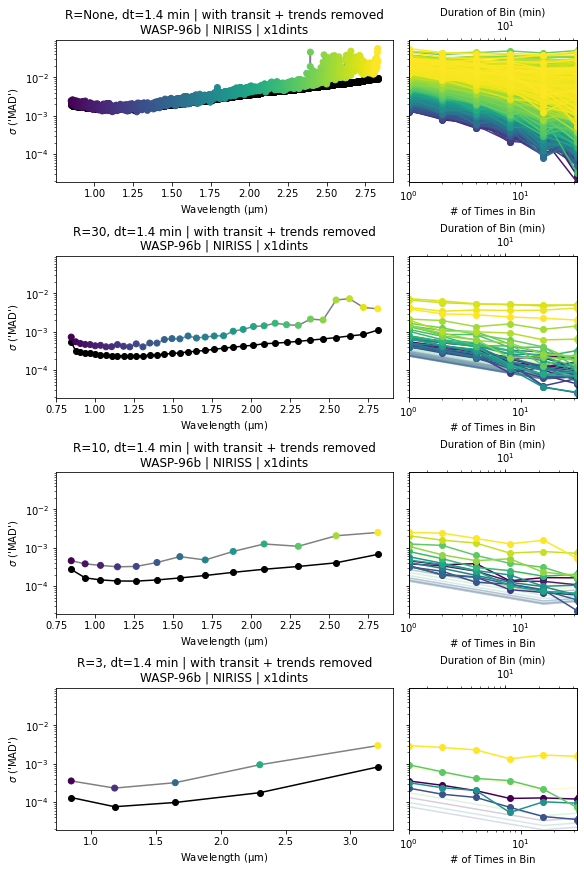

In [23]:
fi, ax = plt.subplots(
    N, 2, sharey=True, figsize=(8, N * 3), gridspec_kw=dict(width_ratios=[2, 1])
)
for i, R in enumerate(binned_rainbows):
    with_trend_removed = binned_rainbows[R].remove_trends(method="polyfit", deg=2)
    with_trend_removed.plot_noise_comparison(ax=ax[i, 0], method="MAD")
    plt.title(
        f"R={R}, dt={binned_rainbows[R].dt:.2} | with transit + trends removed\n{ax[i,0].get_title()}"
    )
    with_trend_removed.plot_noise_comparison_in_bins(ax=ax[i, 1], method="MAD")

That's it! Hopefully these automated visualizations can serve as a useful starting place for understanding the dataset you're working with and for comparing to other analyses. 



## 🗺 Explore Further! 

You can explore other options to visualize or work with your 🌈 data by using the built-in `.help()` method. On any `Rainbow` object, run this to list available options.

In [24]:
rainbow.help()


Hooray for you! You asked for help on what you can do
with this 🌈 object. Here's a quick reference of a few
available options for things to try.

-----------
| actions |
-----------

🌈🧮📝 | +-*/                         
   Do basic math operations with two Rainbows.
🌈🗂🔪 | .[:,:]()                     
   Index, slice, or mask a Rainbow to get a subset.
🌈🚧🌊 | .align_wavelengths()         
   Align spectra with different wavelength grids onto one shared axis.
🌈🧺🧱 | .bin()                       
   Bin to a new wavelength or time grid.
🌈🧑‍🤝‍🧑🌈 | .compare()                   
   Connect to other 🌈 objects for easy comparison.
🌈⏲🎞 | .fold()                      
   Fold times relative to a particular period and epoch.
🌈🧺⏰ | .get_average_lightcurve_as_rainbow() 
   Bin down to a single integrated light curve.
🌈🧺🌊 | .get_average_spectrum_as_rainbow() 
   Bin down to a single integrated spectrum.
🌈🎧🎲 | .inject_noise()              
   Inject (uncorrelated, simple) random noise.
🌈🎧🎹 | .inject_s